In [1]:
# import modules
import pandas as pd

# import data using the pandas library and convert them into a dataframe
raw_data = pd.read_excel('data.xlsx')
raw_data.head()

,Unnamed: 0,Samples,Oxygen vacancy,Polarization,Charge,Electronegativity,Radius A-site,Radius B-site
0,0,La0.1Sr0.9Ta0.15V0.05Co0.8O3-δ,0.29897,9.446629,2.583333,1.190417,1.432,0.611000
1,1,La0.2Sr0.8Ta0.15V0.05Co0.8O3-δ,0.26100,9.766618,2.666667,1.212917,1.424,0.611000
2,2,La0.5Sr0.5Ta0.15V0.05Co0.8O3-δ,0.10030,10.726585,2.916667,1.280417,1.400,0.611000
3,3,Sr1Sc0.175Ta0.025Co0.8O3-δ,0.44474,4.890362,2.208333,1.107292,1.440,0.634375
4,4,Sr0.95Ta0.15V0.05Co0.8O3-δ,0.23646,9.402677,2.521739,1.173913,1.440,0.611000


In [2]:
# take the oxygen vacancy as the label
Y = raw_data.loc[:, 'Oxygen vacancy'].values

# take the other collumns as the features
X = raw_data.iloc[:, 3:]
X.head()

,Polarization,Charge,Electronegativity,Radius A-site,Radius B-site
0,9.446629,2.583333,1.190417,1.432,0.611000
1,9.766618,2.666667,1.212917,1.424,0.611000
2,10.726585,2.916667,1.280417,1.400,0.611000
3,4.890362,2.208333,1.107292,1.440,0.634375
4,9.402677,2.521739,1.173913,1.440,0.611000


In [3]:
from sklearn.utils import shuffle
X, Y = shuffle(X, Y, random_state=0)
X.head()

,Polarization,Charge,Electronegativity,Radius A-site,Radius B-site
129,5.858722,2.545455,1.219091,1.38250,0.609
202,5.691264,2.600000,1.252000,1.28340,0.610
138,7.988591,2.428571,1.235714,1.44000,0.610
66,5.664840,2.500000,1.105000,1.31375,0.610
180,5.389111,2.333333,1.348333,1.33725,0.670


In [4]:
from time import time
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler,QuantileTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)


print("Training MLPRegressor...")
tic = time()
mlp = make_pipeline(
    StandardScaler(),
    MLPRegressor(hidden_layer_sizes=(40, 40), learning_rate_init=0.01, max_iter=500, random_state=0, early_stopping=True),
)

mlp.fit(X_train, y_train)
print(f"done in {time() - tic:.3f}s")
mlp_predictions = mlp.predict(X_test)
# The best R2 should be 1
print(f"Test R2 score: {mlp.score(X_test, y_test):.2f}")

Training MLPRegressor...
done in 0.564s
Test R2 score: 0.54


Computing partial dependence plots...
done in 3.202s


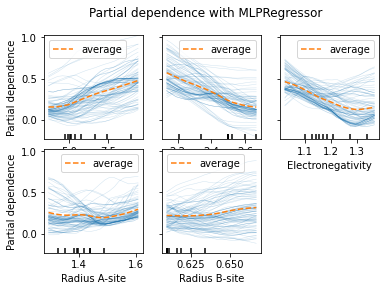

In [5]:
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay

print("Computing partial dependence plots...")
tic = time()
features = ["Polarization", "Charge", "Electronegativity", "Radius A-site", "Radius B-site"]
display = PartialDependenceDisplay.from_estimator(
    mlp,
    X_train,
    features,
    kind="both",
    subsample=100,
    n_jobs=3,
    grid_resolution=20,
    random_state=0,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"},
)
print(f"done in {time() - tic:.3f}s")
display.figure_.suptitle(
    "Partial dependence with MLPRegressor"
)
display.figure_.subplots_adjust(hspace=0.1)

In [6]:
from sklearn.ensemble import HistGradientBoostingRegressor

print("Training HistGradientBoostingRegressor...")
tic = time()
est = HistGradientBoostingRegressor()
est.fit(X_train, y_train)
gbrt_predictions = est.predict(X_test)
print(f"done in {time() - tic:.3f}s")
print(f"Test R2 score: {est.score(X_test, y_test):.2f}")

Training HistGradientBoostingRegressor...
done in 0.260s
Test R2 score: 0.40


Computing partial dependence plots...
done in 0.904s


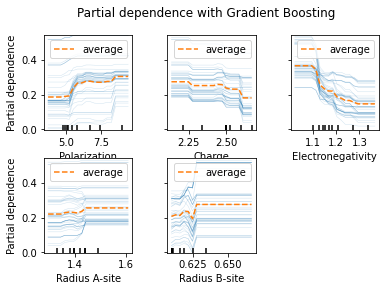

In [7]:
print("Computing partial dependence plots...")
tic = time()
display = PartialDependenceDisplay.from_estimator(
    est,
    X_train,
    features,
    kind="both",
    subsample=50,
    n_jobs=3,
    grid_resolution=20,
    random_state=0,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"},
)
print(f"done in {time() - tic:.3f}s")
display.figure_.suptitle(
    "Partial dependence with Gradient Boosting"
)
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)


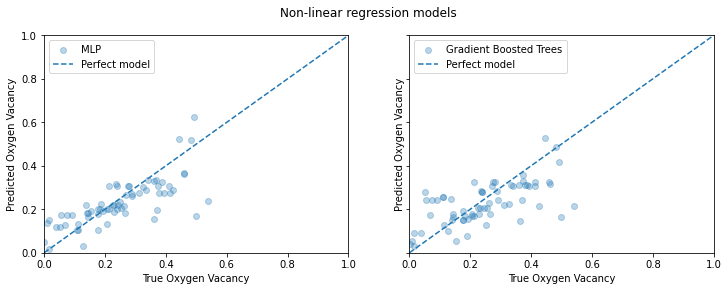

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
fig.suptitle("Non-linear regression models")
predictions = [
    mlp_predictions,
    gbrt_predictions,
]
labels = [
    "MLP",
    "Gradient Boosted Trees",
]
for ax, pred, label in zip(axes, predictions, labels):
    ax.scatter(y_test, pred, alpha=0.3, label=label)
    ax.plot([0, 1], [0, 1], "--", label="Perfect model")
    ax.set(
        xlim=(0, 1),
        ylim=(0, 1),
        xlabel="True Oxygen Vacancy",
        ylabel="Predicted Oxygen Vacancy",
    )
    ax.legend()

In [9]:
mlp_predictions.shape

(67,)

In [10]:
from time import time
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge


from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Visualize learning curves
plt.figure(figsize=(12, 8))

svr = SVR(kernel="rbf", C=1e1, gamma=0.1)


svr.fit(X_train, y_train)
print(f"SVR done in {time() - tic:.3f}s")

# The best R2 should be 1
print(f"Test R2 score: {svr.score(X_test, y_test):.2f}")


kr = KernelRidge(kernel="rbf", alpha=0.1, gamma=0.1)
kr.fit(X_train, y_train)
print(f"Kernel Ridge done in {time() - tic:.3f}s")

# The best R2 should be 1
print(f"Test R2 score: {kr.score(X_test, y_test):.2f}")

rf = RandomForestRegressor(random_state=0)
rf.fit(X_train, y_train)
print(f"Random Forest done in {time() - tic:.3f}s")

# The best R2 should be 1
print(f"Test R2 score: {rf.score(X_test, y_test):.2f}")

SVR done in 2.829s
Test R2 score: 0.41
Kernel Ridge done in 2.862s
Test R2 score: 0.47
Random Forest done in 3.076s
Test R2 score: 0.43


<Figure size 864x576 with 0 Axes>

In [11]:
from time import time
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(random_state=0)
dt.fit(X_train, y_train)
print(f"Random Forest done in {time() - tic:.3f}s")

# The best R2 should be 1
print(f"Test R2 score: {dt.score(X_test, y_test):.2f}")

Random Forest done in 3.119s
Test R2 score: 0.20


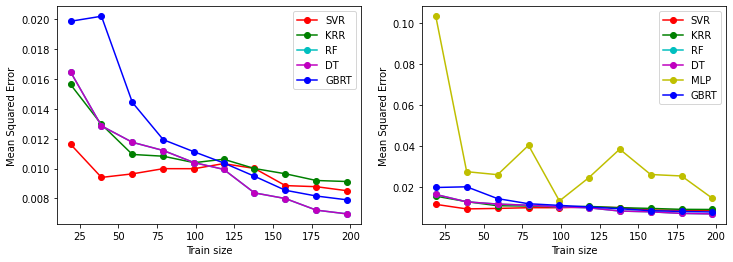

In [12]:
import time
train_sizes, train_scores_svr, test_scores_svr = learning_curve(
    svr,
    X,
    Y,
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=10,
)
train_sizes_abs, train_scores_kr, test_scores_kr = learning_curve(
    kr,
    X,
    Y,
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=10,
)
train_sizes, train_scores_mlp, test_scores_mlp = learning_curve(
    mlp,
    X,
    Y,
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=10,
)
train_sizes_abs, train_scores_rf, test_scores_rf = learning_curve(
    rf,
    X,
    Y,
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=10,
)
train_sizes_abs, train_scores_gbrt, test_scores_gbrt = learning_curve(
    est,
    X,
    Y,
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=10,
)

train_sizes_abs, train_scores_dt, test_scores_dt = learning_curve(
    dt,
    X,
    Y,
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=10,
)
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
for id, ax in enumerate(axes):
    ax.plot(train_sizes, -test_scores_svr.mean(1), "o-", color="r", label="SVR")
    ax.plot(train_sizes, -test_scores_kr.mean(1), "o-", color="g", label="KRR")
    ax.plot(train_sizes, -test_scores_rf.mean(1), "o-", color="c", label="RF")
    ax.plot(train_sizes, -test_scores_rf.mean(1), "o-", color="m", label="DT")
    if id == 1:
        ax.plot(train_sizes, -test_scores_mlp.mean(1), "o-", color="y", label="MLP")
    ax.plot(train_sizes, -test_scores_gbrt.mean(1), "o-", color="b", label="GBRT")
    ax.set(xlabel="Train size",
           ylabel="Mean Squared Error")
    ax.legend(loc="best")
    ax.relim()
    # update ax.viewLim using the new dataLim
    ax.autoscale_view()
plt.show()

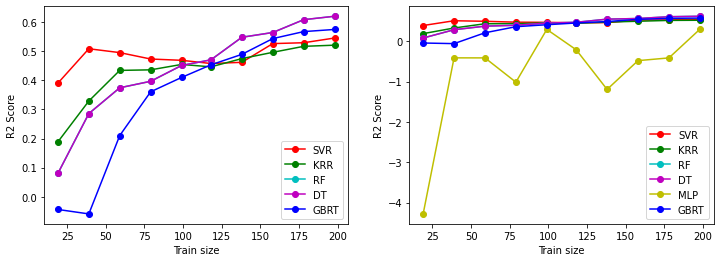

In [13]:
import time
train_sizes, train_scores_svr, test_scores_svr = learning_curve(
    svr,
    X,
    Y,
    train_sizes=np.linspace(0.1, 1, 10),
    cv=10,
)
train_sizes_abs, train_scores_kr, test_scores_kr = learning_curve(
    kr,
    X,
    Y,
    train_sizes=np.linspace(0.1, 1, 10),
    cv=10,
)
train_sizes, train_scores_mlp, test_scores_mlp = learning_curve(
    mlp,
    X,
    Y,
    train_sizes=np.linspace(0.1, 1, 10),
    cv=10,
)
train_sizes_abs, train_scores_gbrt, test_scores_gbrt = learning_curve(
    est,
    X,
    Y,
    train_sizes=np.linspace(0.1, 1, 10),
    cv=10,
)
train_sizes_abs, train_scores_rf, test_scores_rf = learning_curve(
    rf,
    X,
    Y,
    train_sizes=np.linspace(0.1, 1, 10),
    cv=10,
)
train_sizes_abs, train_scores_dt, test_scores_dt = learning_curve(
    dt,
    X,
    Y,
    train_sizes=np.linspace(0.1, 1, 10),
    cv=10,
)
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
for id, ax in enumerate(axes):
    ax.plot(train_sizes, test_scores_svr.mean(1), "o-", color="r", label="SVR")
    ax.plot(train_sizes, test_scores_kr.mean(1), "o-", color="g", label="KRR")
    ax.plot(train_sizes, test_scores_rf.mean(1), "o-", color="c", label="RF")
    ax.plot(train_sizes, test_scores_rf.mean(1), "o-", color="m", label="DT")
    if id == 1:
        ax.plot(train_sizes, test_scores_mlp.mean(1), "o-", color="y", label="MLP")
    ax.plot(train_sizes, test_scores_gbrt.mean(1), "o-", color="b", label="GBRT")
    ax.set(xlabel="Train size",
           ylabel="R2 Score")
    ax.legend(loc="best")

plt.show()

In [15]:
# Hide warnings
import warnings
warnings.filterwarnings("ignore")

# !pip install xgboost
# !pip install lightgbm
# !pip install lazypredict
import pyforest
from lazypredict.Supervised import LazyRegressor
from pandas.plotting import scatter_matrix

# Scikit-learn packages
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error

# Setting up max columns displayed to 100
pd.options.display.max_columns = 100

ModuleNotFoundError: No module named 'sklearn.utils.testing'

In [ ]:
reg = LazyRegressor(predictions=True)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

In [ ]:
print(models)

In [ ]:
type(models)